# ICOM
July 14, 2017

My attempt at directly talking to the RigExpert AA-54 through Python 3.

I'm really only interesting the FRX command, which reports the resistance and reactance of the antenna. The GET and GT commands from their documentation don't work.

To set this up, hook up the antenna to the AA-54, then hook up a serial cable from the computer to the AA-54, and finally turn on the AA-54. It should come up in PC mode (if not, push the up arrow). Then you can run this program to get the R and X data.

In [1]:
import serial

In [2]:
def read_string_response(io, maxchars=12000):
    """
    Read a response from the analyzer.
    
    Returns the string response if OK, or "ERROR" if
    there was an error.
    """
    response = ""
    for k in range(maxchars):
        c = io.read(1)
        #print(c)
        response += c.decode("UTF-8")
        #print(">%s<" % response)
        if response.endswith("ERROR"):
            return "Command error"
        if response.endswith("OK"):
            break
    return response

In [3]:
def convert_float(resp1):
    """
    Convert the string response to a list of floats
    """
    result = []
    resp = resp1[:-2]  # Remove "OK" at end
    lines = resp.splitlines()
    for instring in lines:
        if len(instring) > 0:
            x = []
            s = instring.replace("\n","").replace("\r","").split(",")
            if len(s) > 0:
                for sval in s:
                    x.append(float(sval))
                result.append(x)
    return result

In [4]:
def frx_command(io, n):
    cmd = b"FRX"+bytearray(str(n),"UTF-8")+b"\r"
    io.write(cmd)
    response = read_string_response(io)
    return [response, convert_float(response[:-2])]

In [5]:
def command(io, cmd):
    """
    Send a command to the analyzer and get the response.
    """
    io.write(cmd)
    response = read_string_response(io)
    return response.replace("\n","").replace("\r","")

In [6]:
portname = "/dev/ttyUSB0"
baud = 38400
freq = 52.0    # Frequency in MHz
width = 2000   # Width in kHz

In [7]:
io = serial.Serial(portname,
                   baud,
                   serial.EIGHTBITS,  # bytesize
                   serial.PARITY_NONE,
                   stopbits=serial.STOPBITS_ONE,
                   timeout=1000)

In [8]:
command(io, b"ON\r")

'OK'

In [9]:
s = b"FQ"+bytearray(str(int(1.0e6*freq)),"UTF-8")+b"\r"
command(io, s)

'OK'

In [10]:
s = b"SW"+bytearray(str(int(1.0e3*width)),"UTF-8")+b"\r"
command(io, s)

'OK'

In [11]:
result = frx_command(io, 101)

To print the complete result in tabular form as returned by the analyzer, use
<code>
    print(result[0])
</code>

If you want to see the complete data converted to floating point, use
<code>
    print(result[1])
</code>

Below I will print the R and X values around the center frequency.

In [12]:
print(result[1][49:52])

[[51.970294, 48.3, 3.33], [51.990104, 48.31, 3.19], [52.009902, 49.41, 3.84]]


In [13]:
command(io, b"OFF\r")

'OK'

In [14]:
io.flush()
io.close()

The two lines of code below will graph the results if you run them. They require the matplotlib package. The green lines in this example show the center frequency, and the 50 ohm and 0 ohm lines for reference.

In [15]:
def graphit(freq,width,result):
    import matplotlib
    import matplotlib.pyplot as plt
    %matplotlib inline
    frz = list(map(list, zip(*result[1])))
    plt.plot(frz[0],frz[1],'r-',frz[0],frz[2],'b-',[freq,freq],[-10,80],'g-',[freq-0.001*width,freq+0.001*width],[50,50],'g-',[freq-0.001*width,freq+0.001*width],[0,0],'g-');

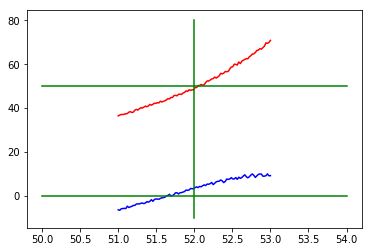

In [16]:
graphit(freq,width,result)